<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/speaker_indep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!pip install fastdtw
!pip install pysptk
!pip install pyworld

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.2.0-cp37-cp37m-linux_x86_64.whl size=931340 sha256=6624f93fdb061aac1f5093989bac7a996bd4e37fc59ae3565e3061ab5e4424b6
  Stored in directory: /root/.cache/pip/wheels/9a/70/a1/757bd6c0017f384831e6260a784f10ff6d7998a805719f9a2d
Successfully built pysptk
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to bu

In [2]:
#obtaining the data
!gdown https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
#reconstruction module
!gdown https://drive.google.com/u/0/uc?id=1KYJD7INBZJ4Wip_ok6nGaJNGHZOCl8ra
#Melfiltebank applier
!gdown https://drive.google.com/u/0/uc?id=16XwS13GUAa7HuJv1Yi1XP6lQm0Gz42Ho

#extracting it
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
To: /content/features.zip
100% 2.14G/2.14G [00:21<00:00, 98.7MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1KYJD7INBZJ4Wip_ok6nGaJNGHZOCl8ra
To: /content/reconstructWave.py
100% 3.02k/3.02k [00:00<00:00, 3.12MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=16XwS13GUAa7HuJv1Yi1XP6lQm0Gz42Ho
To: /content/MelFilterBank.py
100% 2.87k/2.87k [00:00<00:00, 3.05MB/s]


In [3]:
#setting the path
feat_path = r'/content/features'

# the subjects for each set
train_subs = ['sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09','sub-10']
val_subs = ['sub-01', 'sub-02']
test_subs = ['sub-03', 'sub-04']

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# making the train, validation and test sets with Principal Component Analysis 
def make_set(subs, n_comp):
  whole_data = []
  whole_spec = []

  for participant in subs:
    #features with PCA
    data = np.load(os.path.join(feat_path,f'{participant}_feat.npy'))
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    pca = PCA(n_components=n_comp, random_state=0)
    data = pca.fit_transform(data)
    whole_data.append(data)
    #labels
    spec = np.load(os.path.join(feat_path,f'{participant}_spec.npy'))
    whole_spec.append(spec)
  
  features = np.vstack(tuple(whole_data))
  labels = np.vstack(tuple(whole_spec))

  return features, labels

train_data, train_spec = make_set(train_subs, 300)
val_data, val_spec = make_set(val_subs, 300)
test_data, test_spec = make_set(test_subs, 300)

# Modeling

In [5]:
#Setting seed
import tensorflow as tf
tf.keras.utils.set_random_seed(1234)

Simple FC-DNN model

In [6]:
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(inputsize)))
    model.add(tf.keras.layers.Dense(400, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(300, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(200, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(outputsize))
    return model

In [7]:
early_stopping = EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

model = create_dnn_model(300, 23)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(train_data, train_spec, batch_size=64, 
          epochs=100, verbose=1, validation_data=(val_data, val_spec), shuffle=True,
          callbacks=[checkpointer, early_stopping])

Epoch 1/100
2785/2788 [============================>.] - ETA: 0s - loss: 3.8735 - mse: 3.8735
Epoch 1: val_loss improved from inf to 4.52493, saving model to weights.hdf5
2788/2788 [==============================] - 36s 12ms/step - loss: 3.8731 - mse: 3.8731 - val_loss: 4.5249 - val_mse: 4.5249
Epoch 2/100
2787/2788 [============================>.] - ETA: 0s - loss: 2.6127 - mse: 2.6127
Epoch 2: val_loss did not improve from 4.52493
2788/2788 [==============================] - 35s 13ms/step - loss: 2.6127 - mse: 2.6127 - val_loss: 4.7287 - val_mse: 4.7287
Epoch 3/100
2785/2788 [============================>.] - ETA: 0s - loss: 2.2233 - mse: 2.2233
Epoch 3: val_loss did not improve from 4.52493
2788/2788 [==============================] - 34s 12ms/step - loss: 2.2233 - mse: 2.2233 - val_loss: 4.6746 - val_mse: 4.6746
Epoch 4/100
2784/2788 [============================>.] - ETA: 0s - loss: 1.9882 - mse: 1.9882
Epoch 4: val_loss did not improve from 4.52493
2788/2788 [====================

In [8]:
model.load_weights('weights.hdf5')
rec_spec = model.predict(test_data)

1875/1875 [==============================] - 6s 3ms/step


In [9]:
from scipy.stats import pearsonr
import scipy.io.wavfile as wavfile

rs = np.zeros((test_spec.shape[1]))

# Evaluate reconstruction of this fold
for specBin in range(test_spec.shape[1]):
  r, p = pearsonr(test_spec[:, specBin], rec_spec[:, specBin])
  rs[specBin] = r

#Show evaluation result
print('Mean correlation:', np.mean(rs))

Mean correlation: -0.026213530839152812


## MCD

In [10]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV file can be found
  '''
  #computational parameters
  _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
  s = 0.0
  framesTot = 0

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    print("Processing -----------{}".format(subject))
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

  MCD_value = _logdb_const * float(s) / float(framesTot)

  print("MCD = : {:f}".format(MCD_value))


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [11]:
#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

In [12]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [13]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [14]:
#this folder will be needed for the evaluation
!mkdir synth_audio_dnn

In [15]:
test_data4, test_spec4 = make_set(['sub-04'], 300)

In [16]:
rec_spec4 = model.predict(test_data4)

938/938 [==============================] - 3s 3ms/step


In [17]:
reconstructedWav4 = createAudio(rec_spec4,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/sub-04_predicted.wav'),int(audiosr),reconstructedWav4)

In [18]:
orig_bn4 = load_wav('/content/features/sub-04_orig_audio.wav', 16000)
rec_bn4 = load_wav('/content/synth_audio_dnn/sub-04_predicted.wav', 16000)

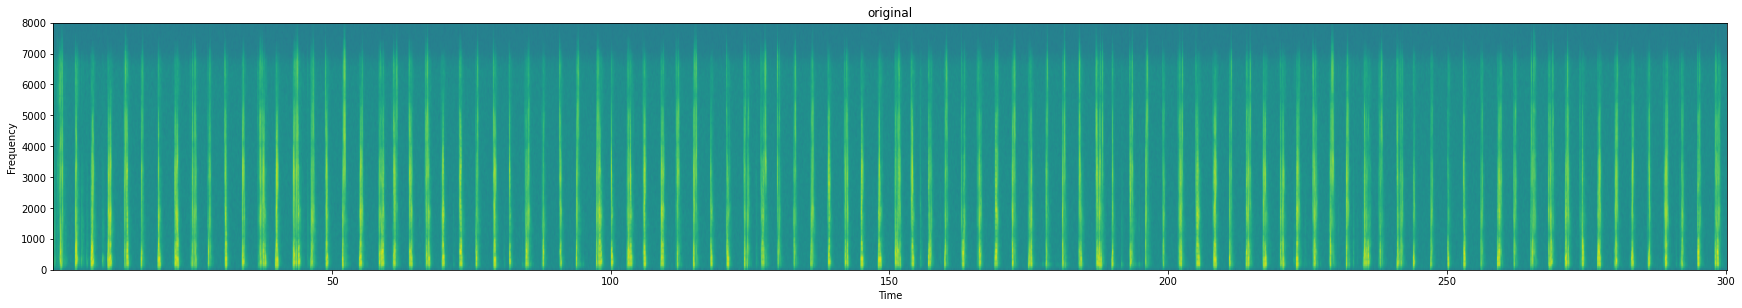

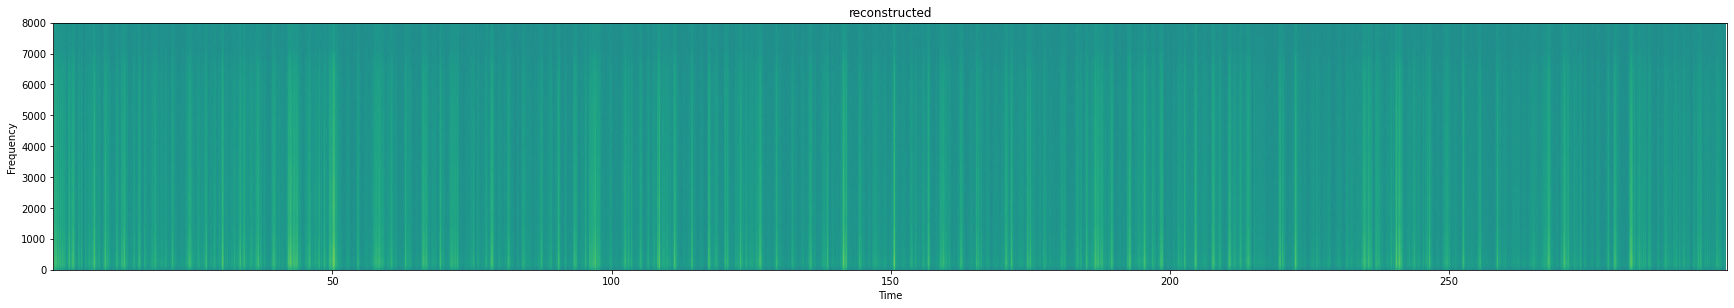

In [21]:
#plotting the spectograms of the original sub-04_orig_audio.wav file and the reconstructed sub-04_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(orig_bn4, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

plt.figure(figsize = (30,10))

plt.subplot(212)
plt.specgram(rec_bn4, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency') 
plt.show()

In [20]:
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-04_predicted.wav
mgc of /content/features/sub-04_orig_audio.wav is ok!
mgc of /content/synth_audio_dnn/sub-04_predicted.wav is ok!
Processing -----------.ipynb_checkpoints


FileNotFoundError: ignored